# Make Figure 1

Steps:
1. Read in all Gaia RR Lyrae data (no cleaning, so use for more than a backdrop at your own peril!)
2. Read in Multinest chains for each of the posteriors
3. Overplot the locations on the the RR Lyrae image

In [11]:

# basic imports
from __future__ import print_function
import numpy as np
from numpy.linalg import eig, inv
import time



import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline
import scipy

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2



# plotting elements
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
cmap = cm.RdBu_r

import matplotlib as mpl
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.minor.visible'] = True




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:

def norm_histogram(arr,bins=-1):
    """ make a verys simple normalised histogram"""
    
    if bins == -1:
        bins = int(len(arr)/100.)
        
    a = np.percentile(arr,0.0)
    A = np.percentile(arr,99.9)
    binvals = np.linspace(a,A,bins)
    outvals = np.zeros(binvals.size)
    #print(a,A,bins)
    da = (A-a)/(bins)
    
    for val in arr:
        #print(val-a,(val-a)/(da))
        indx = (val-a)/da
        if indx>bins-1: indx=bins-1
        #print(indx)
        outvals[int(indx)] += 1
        
    return binvals,outvals/(len(arr)*(A-a)/(bins-1))




## Load up RR Lyrae data

In [13]:
'''
# get the rr lyrae FROM gaia variable classifier

# this is the AQDL call
SELECT gaia.source_id,gaia.ra,gaia.ra_error,gaia.dec,gaia.dec_error,
gaia.parallax,gaia.parallax_error,gaia.pmra,gaia.pmra_error,
gaia.pmdec,gaia.pmdec_error,gaia.phot_g_mean_flux,gaia.phot_g_mean_flux_error,
gaia.phot_g_mean_mag,gaia.phot_bp_mean_flux,gaia.phot_bp_mean_flux_error,
gaia.bp_rp,gaia.radial_velocity,gaia.radial_velocity_error,
variables.best_class_name,variables.best_class_score,gaia.teff_val,gaia.a_g_val
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.vari_classifier_result AS variables 
    ON variables.source_id = gaia.source_id


'''

# RR Lyrae from vari_classifier_result: this is too large to pass around, so you'll have to grab your own version
GRRV = np.genfromtxt('../Shells/data/gaia_allvariable.csv',\
                        dtype={'names': ("gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "best_class_name","best_class_score","teff_val","a_g_val"),\
                             'formats': ('f16','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'S20','f8','f8','f8')},\
                 skip_header=1,delimiter=',')





In [14]:
'''

# just from rrlyrae table: specific object study

SELECT gaia.source_id,gaia.ra,gaia.ra_error,gaia.dec,gaia.dec_error,
gaia.parallax,gaia.parallax_error,gaia.pmra,gaia.pmra_error,
gaia.pmdec,gaia.pmdec_error,gaia.phot_g_mean_flux,gaia.phot_g_mean_flux_error,
gaia.phot_g_mean_mag,gaia.phot_bp_mean_flux,gaia.phot_bp_mean_flux_error,
gaia.bp_rp,gaia.radial_velocity,gaia.radial_velocity_error,
variables.metallicity,variables.best_classification,gaia.teff_val,gaia.a_g_val
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.vari_rrlyrae AS variables 
    ON variables.source_id = gaia.source_id

'''

# RR Lyrae from specific object studies (SOS)
GRRL = np.genfromtxt('../Shells/data/varirrlyrae.csv',\
                        dtype={'names': ("gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "metallicity","best_class","teff_val","a_g_val","ebv"),\
                             'formats': ('f16','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','S20','f8','f8','f8')},\
                 skip_header=1,delimiter=',')





In [17]:
#RAJ2000;DEJ2000;GLON;GLAT;gmag;u-g;D0.2;fm;cHg;bHg;d;r;x;y;z;HRV;e_HRV;Vgal;DR8;Sloan;SimbadName


#RAJ2000;DEJ2000;S3ab;S3c;DM;Per;phi0;gAmp;rAmp;iAmp;zAmp;gmag;rmag;imag;zmag;<gmag>;<rmag>;<imag>;
#<zmag>;E(B-V);S10;PS1;Sloan;SimbadName

S17 = np.genfromtxt('../Shells/data/Sesar17.txt',\
                        dtype={'names': ("ra","dec","S3ab","S3c",\
                                         "DM","Per","phi0","gAmp",\
                                         "rAmp","iAmp","zAmp","gmag",\
                                         "rmag","imag","zmag","gmaga",\
                                        "rmaga","imaga","zmaga","ebv",\
                                        "S10","PS1","SL","Simbad"),\
                             'formats': ('f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                         'f8','S20','S20','S20')},\
                 skip_header=81,delimiter=';')



# cross match of Sesar and Gaia data
Gmatch = np.genfromtxt('../Shells/SesarGaiaComp.csv',\
                        dtype={'names': ("xsource_id","gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","dist"),\
                             'formats': ('i4','f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8')},\
                 skip_header=1,delimiter=',')






In [8]:


# set the coordinates for transformation

# use the schonrich 2010 peculiar motions
usun = 11.1
vsun = 12.24
wsun = 7.25

# use the circular velocity from ...
vcirc = 235.

# the value of mcmillan 2017
vcirc = 232.

# use the gravity 2018 result for the galactic center distance
rsun = 8.3 # in kpc

# use the sun's height above the midplane from Bovy...
zsun = 30 # in pc

v_sun = coord.CartesianDifferential([usun, vsun+vcirc, wsun]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=rsun*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=zsun*u.pc)


class dataset(object):
    '''placeholder for all the quantities we want
    '''
    ra = None
    dec = None
    l = None
    b = None
    d = None
    x = None
    y = None
    z = None
    vx = None
    vy = None
    vz = None
    r = None
    th = None
    ph = None
    vr = None
    vth = None
    vph = None
    pmra = None
    pmdec = None
    epmra = None
    epmdec = None
    vrad = None
    evrad = None
    feh = None
    gflux = None

    
class newcoordinates():
    """take a system with
    
    ra,dec,ra_error,dec_error,pmra,pmdec,pmra_error,pmdec_error,dist,dist_error
    
    """
    
    def __init__(self,inputcatalog,errors=False):
        """take input catalog and make homogenous system
        
        how do we treat missing data in this framework?
        
        """
        
        self.ra       = inputcatalog['ra']
        self.dec      = inputcatalog['dec']
        self.d        = inputcatalog['d']
        self.pmra     = inputcatalog['pmra']
        self.pmdec    = inputcatalog['pmdec']
        self.vrad     = inputcatalog['vrad']

    
        if errors:
            self.raerr    = inputcatalog['raerr']
            self.decerr   = inputcatalog['decerr']
            self.derr     = inputcatalog['derr']        
            self.pmraerr  = inputcatalog['pmraerr']        
            self.pmdecerr = inputcatalog['pmdecerr']        
            self.vraderr  = inputcatalog['vraderr']
        
        
    def find_covariances(self):
        """look at the errors and find real estimates for errors based on the covariances
        
        -should we brute force the errors as a monte carlo?
        
        """
        
        cplus = coord.SkyCoord(ra  = self.ra    + self.raerr    * u.deg,\
                   dec             = self.dec   + self.decerr   * u.deg,\
                   distance        = self.d     + self.derr     * u.kpc,\
                   pm_ra_cosdec    = self.pmra  + self.pmraerr  * u.mas/u.yr,\
                   pm_dec          = self.pmdec + self.pmdecerr * u.mas/u.yr,\
                   radial_velocity = self.vrad  + self.vraderr  * u.km/u.s)
        


    def gc_transform(self):
        '''define a galactic transform
        
        '''
        
        c = coord.SkyCoord(ra      = self.ra    * u.deg,\
                   dec             = self.dec   * u.deg,\
                   distance        = self.d     * u.kpc,\
                   pm_ra_cosdec    = self.pmra  * u.mas/u.yr,\
                   pm_dec          = self.pmdec * u.mas/u.yr,\
                   radial_velocity = self.vrad  * u.km/u.s)
        

        gal_defined = c.transform_to(gc_frame)
        gal_latlon  = c.transform_to('galactic')
        
        self.x = gal_defined.x
        self.y = gal_defined.y
        self.z = gal_defined.z
        
        self.vx = gal_defined.v_x
        self.vy = gal_defined.v_y
        self.vz = gal_defined.v_z

        # do a transform of l to the correct orientation?
        tmpl = gal_latlon.l
        
        self.l = 360.-np.array(tmpl)

        self.l[self.l>180.] -= 360.
        self.l *= -1.
        
        
        
        self.b = gal_latlon.b
        
        # be careful about the cos(b) term included here...
        self.vl = gal_latlon.pm_l_cosb
        self.vb = gal_latlon.pm_b

    def sph_transform(self):
        """convert cartesian to spherical
        """
        self.rho = np.sqrt(self.x*self.x + self.y*self.y + self.z*self.z)
        self.r = np.sqrt(self.x*self.x + self.y*self.y)
        self.theta = np.arctan2(self.y,self.x)
        self.phi = np.arccos(self.z/self.r)

        self.vr = (self.x*self.vx + self.y*self.vy + self.z*self.vz)/self.rho
        self.vtheta = (self.vx*self.y - self.x*self.vy)/(self.r*self.r)
        self.vphi = ( self.z*(self.x*self.vx + self.y*self.vy) \
                     - self.r*self.r*self.vz )/(self.rho*self.rho*self.r)   
        
        
    

    

In [10]:

uni_ids,uni_indx = np.unique(np.concatenate([GRRV['gsource_id'][rrls2],GRRL['gsource_id'][rrls1]]),return_index=True)



uni_ra = np.concatenate([GRRV['ra'][rrls2],GRRL['ra'][rrls1]])[uni_indx]
uni_dec = np.concatenate([GRRV['dec'][rrls2],GRRL['dec'][rrls1]])[uni_indx]

uni_g = np.concatenate([GRRV['phot_g_mean_mag'][rrls2],GRRL['phot_g_mean_mag'][rrls1]])[uni_indx]

uni_noise = np.concatenate([GRRV['pmdec_error'][rrls2],GRRL['pmdec_error'][rrls1]])[uni_indx]
uni_signal = np.concatenate([GRRV['pmdec'][rrls2],GRRL['pmdec'][rrls1]])[uni_indx]

uni_noise2 = np.concatenate([GRRV['pmra_error'][rrls2],GRRL['pmra_error'][rrls1]])[uni_indx]
uni_signal2 = np.concatenate([GRRV['pmra'][rrls2],GRRL['pmra'][rrls1]])[uni_indx]






c = coord.SkyCoord(ra=uni_ra*u.deg,\
                   dec=uni_dec*u.deg,\
                   distance=np.ones(uni_ids.size)*u.kpc)


rrg = c.transform_to('galactic') # for specific coordinates set above


print(rrg.l.size)




225108


In [9]:

uni_ids,uni_indx = np.unique(np.concatenate([GRRV['gsource_id'][rrls2],GRRL['gsource_id'][rrls1],\
                                             Gmatch['gsource_id']]),return_index=True)



uni_ra = np.concatenate([GRRV['ra'][rrls2],GRRL['ra'][rrls1],\
                         Gmatch['ra']])[uni_indx]
uni_dec = np.concatenate([GRRV['dec'][rrls2],GRRL['dec'][rrls1],\
                          Gmatch['dec']])[uni_indx]

uni_g = np.concatenate([GRRV['phot_g_mean_mag'][rrls2],GRRL['phot_g_mean_mag'][rrls1],Gmatch['phot_g_mean_mag']])[uni_indx]

uni_noise = np.concatenate([GRRV['pmdec_error'][rrls2],GRRL['pmdec_error'][rrls1],Gmatch['pmdec_error']])[uni_indx]
uni_signal = np.concatenate([GRRV['pmdec'][rrls2],GRRL['pmdec'][rrls1],Gmatch['pmdec']])[uni_indx]

uni_noise2 = np.concatenate([GRRV['pmra_error'][rrls2],GRRL['pmra_error'][rrls1],Gmatch['pmra_error']])[uni_indx]
uni_signal2 = np.concatenate([GRRV['pmra'][rrls2],GRRL['pmra'][rrls1],Gmatch['pmra']])[uni_indx]






c = coord.SkyCoord(ra=uni_ra*u.deg,\
                   dec=uni_dec*u.deg,\
                   distance=np.ones(uni_ids.size)*u.kpc)


rrg = c.transform_to('galactic') # for specific coordinates set above


print(rrg.l.size)



NameError: name 'Gmatch' is not defined

In [22]:
# try a simple 2d histogram
lbins = np.linspace(-180.,180.,1000)
bbins = np.linspace(-90.,90.,1000)

img = np.zeros([lbins.size,bbins.size])

lvals = np.array(rrg.l)
bvals = np.array(rrg.b)

lvals[lvals>180.] -=360.

for i in range(0,lvals.size):
    lindx = int(lbins.size*(lvals[i]+180.)/360.)
    bindx = int(lbins.size*(bvals[i]+90.)/180.)
    
    #print(lindx,bindx)
        
    if ((lindx>0)&(lindx<lbins.size-1)&(bindx>0)&(bindx<bbins.size-1)):
        img[lindx,bindx] += 1
    

In [23]:
allcolor = 'silver'#'lightgray'#'blueviolet'#'red'#'pink'
kcolor = 'indianred'#'crimson'#'pink'#'red'
bhbcolor = 'dodgerblue'
satcolor = 'cyan'
satcolor = 'orange'

In [24]:
imgf = np.log10(img.T.reshape(-1,))

crange = np.linspace(np.nanpercentile(imgf,89.3),np.nanpercentile(imgf,96.8),48)


print(crange)

#manually adjust downward...
crange = np.linspace(0.,0.2,48)



dc = crange[1]-crange[0]



[0.         0.01015152 0.02030303 0.03045455 0.04060606 0.05075758
 0.0609091  0.07106061 0.08121213 0.09136364 0.10151516 0.11166668
 0.12181819 0.13196971 0.14212122 0.15227274 0.16242426 0.17257577
 0.18272729 0.19287881 0.20303032 0.21318184 0.22333335 0.23348487
 0.24363639 0.2537879  0.26393942 0.27409093 0.28424245 0.29439397
 0.30454548 0.314697   0.32484851 0.33500003 0.34515155 0.35530306
 0.36545458 0.37560609 0.38575761 0.39590913 0.40606064 0.41621216
 0.42636367 0.43651519 0.44666671 0.45681822 0.46696974 0.47712125]


## Read in posteriors

In [18]:
import kde as kde_3d

# set colors for the posteriors
allcolor = 'silver'
kcolor = 'indianred'
bhbcolor = 'dodgerblue'
satcolor = 'cyan'
satcolor = 'orange'

In [19]:
def read_posterior(pfile):
    """read posteriors coming from Multinest"""
    
    A = np.genfromtxt(pfile)
    
    dname = {}
    dname['vtravel'] = A[:,0]
    dname['phi'] = (180./np.pi)*A[:,1]
    dname['phi'][dname['phi']<0] += 360.
    dname['theta'] = 90.-(180./np.pi)*np.arccos(A[:,2])
    dname['sigmar'] = 1./np.sqrt(A[:,3])
    dname['sigmap'] = 1./np.sqrt(A[:,4])
    dname['sigmat'] = 1./np.sqrt(A[:,5])
    dname['vra'] = A[:,6]
    dname['vth'] = A[:,7]
    dname['vphi'] = A[:,8]
    
    return dname


SAT = read_posterior('/Users/mpetersen/Dropbox/mike/data/satellites_mcconnachie_minimum.posteriors')
KGiants = read_posterior('/Users/mpetersen/Dropbox/mike/data/KGiants_d040150_sgr20_L3000_corr.posteriors2')
#SAT = read_posterior('/Users/mpetersen/Dropbox/mike/data/satellites_original_minimum.posteriors')
BHB = read_posterior(      '/Users/mpetersen/Dropbox/mike/data/BHBs_d040150_sgr20_L3000_lanc_corr.posteriors2')
ALL = read_posterior('/Users/mpetersen/Dropbox/mike/data/all_d040150_sgr20_L3000_cov.posteriors2')




cats = ['vtravel','phi','theta','sigmar','sigmap','sigmat','vra','vth','vphi']
dictnames = [ALL,BHB,KGiants,SAT]

def total_bounds(dictnames,cats):
    """find the boundaries from posteriors"""
    
    bounddict = {}
    
    for cat in cats:
        bounddict[cat] = [np.percentile(np.array(np.concatenate([dictname[cat] for dictname in dictnames])),0.2),\
                          np.percentile(np.array(np.concatenate([dictname[cat] for dictname in dictnames])),99.8)]

    return bounddict

bounddict = total_bounds(dictnames,cats)



def make_banana(array1,array2,bounds=[-1,-1,-1,-1],gridsize=128):
    """bin data to make the banana plots"""
    
    a,A = np.nanmin(array1),np.nanmax(array1)
    b,B = np.nanmin(array2),np.nanmax(array2)
    da,db = (A-a)/128.,(B-b)/128.
    
    if bounds[0]==bounds[1]:
        bounds = [a,A,b,B]
    
    
    xx,yy,dens = kde_3d.total_kde_two(array1,array2,\
                                       gridsize=gridsize,\
                                       extents=bounds,\
                                       ktype='gaussian',npower=8.)


    #print(da,db)
    return xx,yy,np.flipud(dens),da*db



def plot_aitoff_banana(ax,catx,caty,color,border=False,bounds=[-1,-1,-1,-1],gridsize=100,binset=[92.,98.,99.5],alphaspace=0.2,zorder=0):


    xx,yy,dens,dadb = make_banana(catx,caty,bounds=bounds,gridsize=gridsize)
    densflat = dens.reshape(-1,)
    bins = np.percentile(densflat,binset)
    for ib,b in enumerate(bins):
        lobin = bins[ib]
        if ib==(len(bins)-1):
            hibin = np.inf
        else:
            hibin = bins[ib+1]
        if border:
            #print(1+ib)
            ax.contourf(xx,yy,dens,[lobin,hibin],colors=color,alpha=alphaspace*(1+ib)+0.4,zorder=zorder)
        else:
            ax.contourf(xx,yy,dens,[lobin,hibin],colors=color,alpha=alphaspace*(1+ib)+0.4,zorder=zorder)
            

dictnames = [BHB,KGiants,SAT,ALL]
colorlist = ['blue','red','cyan','black']









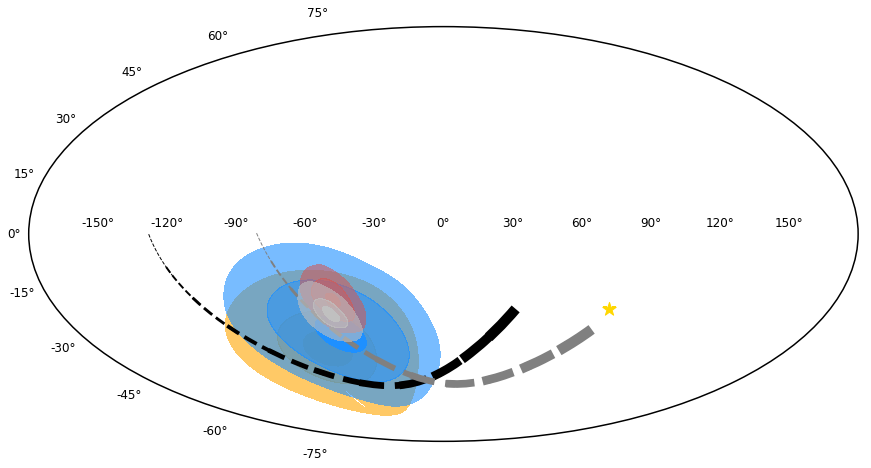

In [20]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0.0,0.02,1.,.96], projection="aitoff")


from reflexmotion import modelsats as ms
PHIP           = 178.45* np.pi/180.0;
THETA          = 114.89* np.pi/180.0;
PSI            = 54.05* np.pi/180.0;

PSI            = 9.05* np.pi/180.0;


Trans = ms.return_euler_slater(PHIP, THETA, PSI, 0)

phitest = np.linspace(1.42*np.pi,2.3*np.pi,50)
In0 = np.cos(phitest);
In1 = np.sin(phitest);
In2 = 0.0;
twisted  = np.dot(Trans,np.array([In0,In1,In2]))

#plt.plot(In0,In1)
#plt.plot(twisted[0],twisted[1])

lvals = -np.arctan2(twisted[1],twisted[0]) - 47.*np.pi/180.
bvals = -np.arcsin(twisted[2])


for indx in range(0,lvals.size-4,4):
    ax.plot(lvals[indx:indx+6],bvals[indx:indx+6],color='black',linestyle='dashed',lw=indx*0.24,zorder=92)


phitest = np.linspace(1.42*np.pi,2.27*np.pi,50)
In0 = np.cos(phitest);
In1 = np.sin(phitest);
In2 = 0.0;
twisted  = np.dot(Trans,np.array([In0,In1,In2]))

#plt.plot(In0,In1)
#plt.plot(twisted[0],twisted[1])

lvals = -np.arctan2(twisted[1],twisted[0])# - 47.*np.pi/180.
bvals = -np.arcsin(twisted[2])


for indx in range(0,lvals.size-4,4):
    ax.plot(lvals[indx:indx+6],bvals[indx:indx+6],color='gray',linestyle='dashed',lw=indx*0.24,zorder=92)




ax.scatter(80.*np.pi/180.,-30.*np.pi/180.,color='gold',marker='*',s=200)
#ax.scatter(lvals,bvals,color='black')#,linestyle='dashed',lw=1.5,zorder=92)



plot_aitoff_banana(ax,-(np.pi/180.)*(KGiants['phi']),(np.pi/180.)*KGiants['theta'],kcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=120,binset=[90.,96.,99.5],zorder=90)

plot_aitoff_banana(ax,-(np.pi/180.)*(SAT['phi']),(np.pi/180.)*SAT['theta'],satcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=100,binset=[92.,98.,99.5],zorder=88)

plot_aitoff_banana(ax,-(np.pi/180.)*(BHB['phi']),(np.pi/180.)*BHB['theta'],bhbcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=120,binset=[90.,96.,99.5],zorder=89)

allcolor='silver'
plot_aitoff_banana(ax,-(np.pi/180.)*ALL['phi'],(np.pi/180.)*ALL['theta'],allcolor,border=True,bounds=[-1,-1,-1,-1],gridsize=120,binset=[92.,98.,99.5],zorder=100)









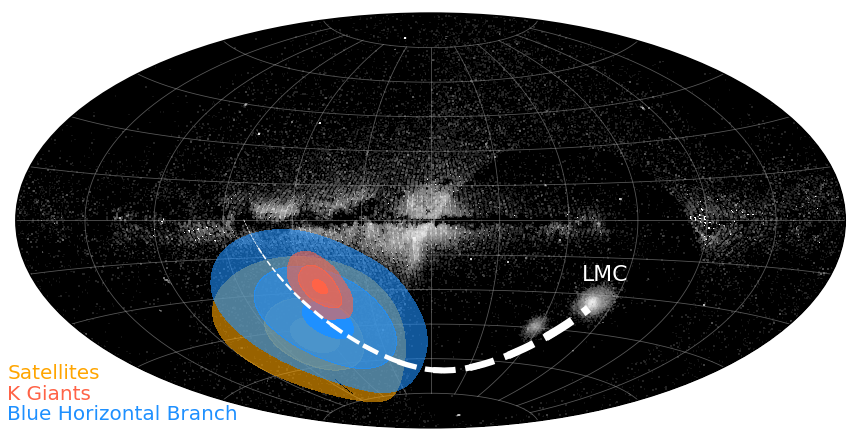

In [36]:

kcolor = 'tomato'#'crimson'#'pink'#'red'



fig = plt.figure(figsize=(12,6))
#ax = plt.subplot(111, projection="aitoff")
ax = fig.add_axes([0.0,0.02,1.,.96], projection="aitoff")


crange = np.linspace(np.nanpercentile(imgf,91.),np.nanpercentile(imgf,100.),72)
#crange = np.linspace(np.nanpercentile(imgf,91.),np.nanpercentile(imgf,95.),48)



LL,BB = np.meshgrid(lbins,bbins)

imgf = np.log10(img.T.reshape(-1,))

# first layer: background black points
cvals = (imgf/np.nanmax(crange))[~np.isfinite(imgf)]

LLf = LL.reshape(-1,)[~np.isfinite(imgf)]
BBf = BB.reshape(-1,)[~np.isfinite(imgf)]

ax.scatter(-LLf*np.pi/180.,
           BBf*np.pi/180.,
           color='black',s=1.,marker='s')

# define the transition between second and fourth layers
colorcut = 2.0

# second layer: dark points
incbrightness = 0.15


cvals = (imgf/np.nanmax(crange))[np.isfinite(imgf)]

LLf = LL.reshape(-1,)[np.isfinite(imgf)][cvals<=colorcut]
BBf = BB.reshape(-1,)[np.isfinite(imgf)][cvals<=colorcut]
smlrg = np.argsort(cvals[cvals<=colorcut])

ax.scatter(-LLf[smlrg]*np.pi/180.,
           BBf[smlrg]*np.pi/180.,
           color=cm.Greys_r(cvals[cvals<=colorcut][smlrg],1.),s=0.13,marker='s')






# third layer: trajectory and posteriors
for indx in range(0,lvals.size-5,4):
    ax.plot(lvals[indx:indx+6],bvals[indx:indx+6],color='white',linestyle='dashed',lw=indx*0.19,zorder=92)



dictnames = [BHB,KGiants,SAT,ALL]
colorlist = ['blue','red','cyan','black']
colorlist = ['salmon','orange','salmon','cyan']




plot_aitoff_banana(ax,-(np.pi/180.)*(KGiants['phi']),(np.pi/180.)*KGiants['theta'],kcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=120,binset=[90.,96.,99.5],zorder=90)

plot_aitoff_banana(ax,-(np.pi/180.)*(SAT['phi']),(np.pi/180.)*SAT['theta'],satcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=100,binset=[92.,98.,99.5],zorder=88)

plot_aitoff_banana(ax,-(np.pi/180.)*(BHB['phi']),(np.pi/180.)*BHB['theta'],bhbcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=120,binset=[90.,96.,99.5],zorder=89)

#allcolor='silver'
#plot_aitoff_banana(ax,-(np.pi/180.)*ALL['phi'],(np.pi/180.)*ALL['theta'],allcolor,border=True,bounds=[-1,-1,-1,-1],gridsize=120,binset=[92.,98.,99.5],zorder=91)



# fourth layer: bright stellar points


cvals = (imgf/np.nanmax(crange))[np.isfinite(imgf)]

LLf = LL.reshape(-1,)[np.isfinite(imgf)][cvals>colorcut]
BBf = BB.reshape(-1,)[np.isfinite(imgf)][cvals>colorcut]
smlrg = np.argsort(cvals[cvals>colorcut])

ax.scatter(-LLf[smlrg]*np.pi/180.,
           BBf[smlrg]*np.pi/180.,
           color=cm.Greys_r(cvals[cvals>colorcut][smlrg]+incbrightness,1.),s=0.13,marker='s',zorder=100)



ax.grid(True,alpha=0.5)
ax.set_xticklabels(())
ax.set_yticklabels(())

ax.text(0.01, 0.098+0.048, 'Satellites', color=satcolor, transform=fig.transFigure,fontsize=20,va='center',ha='left')
#ax.text(0.01,0.098+0.048, 'Combined stars', color=allcolor, transform=fig.transFigure,fontsize=16,va='center',ha='left')
ax.text(0.01, 0.098, 'K Giants', color=kcolor, transform=fig.transFigure,fontsize=20,va='center',ha='left')
ax.text(0.01, 0.05, 'Blue Horizontal Branch', color=bhbcolor, transform=fig.transFigure,fontsize=20,va='center',ha='left')





ax.text((np.pi/180.)*80.,(np.pi/180.)*-22.,'LMC',\
        color='white',size=22,ha='center',va='center')#,bbox=dict(facecolor='white', edgecolor='black',pad=2))
#ax.text((np.pi/180.)*55.,(np.pi/180.)*-37.,'SMC',\
#        color='white',size=16,ha='center',va='center')#,bbox=dict(facecolor='white', edgecolor='black',pad=2))
#ax.text((np.pi/180.)*3.,(np.pi/180.)*-20.,'Sgr',\
#        color='white',size=12,ha='center',va='center')#,bbox=dict(facecolor='white', edgecolor='black',pad=2))






ax.grid(True,alpha=0.5,zorder=10)
ax.set_xticklabels(())
ax.set_yticklabels(())


plt.savefig('figures/figure1b.png',dpi=400)







In [ ]:
convert figures/figure1b.png ~/Desktop/Nature/Figures/Figure1Proposal.pdf
pdftops -eps -level3 ~/Desktop/Nature/Figures/Figure1Proposal.pdf ~/Downloads/Figure1Proposal.eps
rm ~/Desktop/Nature/Figures/Figure1Proposal.pdf



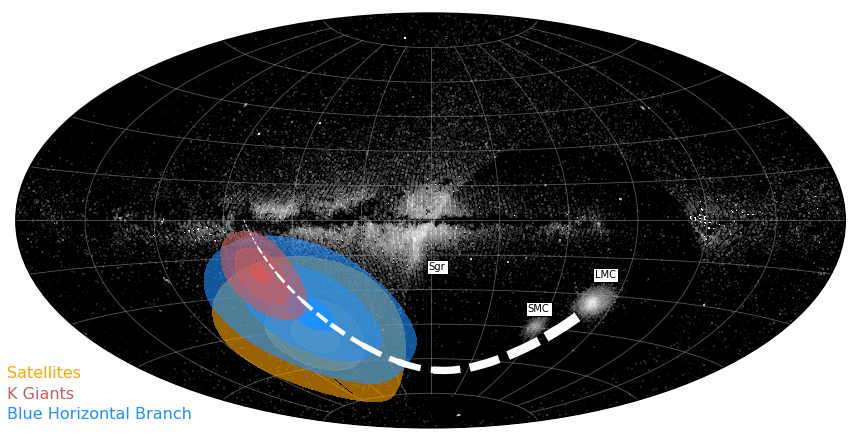

In [129]:

fig = plt.figure(figsize=(12,6))
#ax = plt.subplot(111, projection="aitoff")
ax = fig.add_axes([0.0,0.02,1.,.96], projection="aitoff")


crange = np.linspace(np.nanpercentile(imgf,91.),np.nanpercentile(imgf,100.),72)
#crange = np.linspace(np.nanpercentile(imgf,91.),np.nanpercentile(imgf,95.),48)



LL,BB = np.meshgrid(lbins,bbins)

imgf = np.log10(img.T.reshape(-1,))

# first layer: background black points
cvals = (imgf/np.nanmax(crange))[~np.isfinite(imgf)]

LLf = LL.reshape(-1,)[~np.isfinite(imgf)]
BBf = BB.reshape(-1,)[~np.isfinite(imgf)]

ax.scatter(-LLf*np.pi/180.,
           BBf*np.pi/180.,
           color='black',s=1.,marker='s')

# define the transition between second and fourth layers
colorcut = 2.0

# second layer: dark points
incbrightness = 0.15


cvals = (imgf/np.nanmax(crange))[np.isfinite(imgf)]

LLf = LL.reshape(-1,)[np.isfinite(imgf)][cvals<=colorcut]
BBf = BB.reshape(-1,)[np.isfinite(imgf)][cvals<=colorcut]
smlrg = np.argsort(cvals[cvals<=colorcut])

ax.scatter(-LLf[smlrg]*np.pi/180.,
           BBf[smlrg]*np.pi/180.,
           color=cm.Greys_r(cvals[cvals<=colorcut][smlrg],1.),s=0.13,marker='s')






# third layer: trajectory and posteriors
for indx in range(0,lvals.size-4,4):
    ax.plot(lvals[indx:indx+6],bvals[indx:indx+6],color='white',linestyle='dashed',lw=indx*0.23,zorder=92)



dictnames = [BHB,KGiants,SAT,ALL]
colorlist = ['blue','red','cyan','black']
colorlist = ['salmon','orange','salmon','cyan']

plot_aitoff_banana(ax,-(np.pi/180.)*(KGiants['phi']),(np.pi/180.)*KGiants['theta'],kcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=120,binset=[90.,96.,99.5],zorder=90)

plot_aitoff_banana(ax,-(np.pi/180.)*(SAT['phi']),(np.pi/180.)*SAT['theta'],satcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=100,binset=[92.,98.,99.5],zorder=88)

plot_aitoff_banana(ax,-(np.pi/180.)*(BHB['phi']),(np.pi/180.)*BHB['theta'],bhbcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=120,binset=[90.,96.,99.5],zorder=89)

#allcolor='silver'
#plot_aitoff_banana(ax,-(np.pi/180.)*ALL['phi'],(np.pi/180.)*ALL['theta'],allcolor,border=True,bounds=[-1,-1,-1,-1],gridsize=120,binset=[92.,98.,99.5],zorder=91)



# fourth layer: bright stellar points


cvals = (imgf/np.nanmax(crange))[np.isfinite(imgf)]

LLf = LL.reshape(-1,)[np.isfinite(imgf)][cvals>colorcut]
BBf = BB.reshape(-1,)[np.isfinite(imgf)][cvals>colorcut]
smlrg = np.argsort(cvals[cvals>colorcut])

ax.scatter(-LLf[smlrg]*np.pi/180.,
           BBf[smlrg]*np.pi/180.,
           color=cm.Greys_r(cvals[cvals>colorcut][smlrg]+incbrightness,1.),s=0.13,marker='s',zorder=100)



ax.grid(True,alpha=0.5)
ax.set_xticklabels(())
ax.set_yticklabels(())

ax.text(0.01, 0.098+0.048, 'Satellites', color=satcolor, transform=fig.transFigure,fontsize=16,va='center',ha='left')
#ax.text(0.01,0.098+0.048, 'Combined stars', color=allcolor, transform=fig.transFigure,fontsize=16,va='center',ha='left')
ax.text(0.01, 0.098, 'K Giants', color=kcolor, transform=fig.transFigure,fontsize=16,va='center',ha='left')
ax.text(0.01, 0.05, 'Blue Horizontal Branch', color=bhbcolor, transform=fig.transFigure,fontsize=16,va='center',ha='left')





ax.text((np.pi/180.)*80.,(np.pi/180.)*-22.,'LMC',\
        color='black',size=10,ha='center',va='center',bbox=dict(facecolor='white', edgecolor='black',pad=2))
ax.text((np.pi/180.)*55.,(np.pi/180.)*-37.,'SMC',\
        color='black',size=10,ha='center',va='center',bbox=dict(facecolor='white', edgecolor='black',pad=2))
ax.text((np.pi/180.)*3.,(np.pi/180.)*-20.,'Sgr',\
        color='black',size=10,ha='center',va='center',bbox=dict(facecolor='white', edgecolor='black',pad=2))






ax.grid(True,alpha=0.5,zorder=10)
ax.set_xticklabels(())
ax.set_yticklabels(())


plt.savefig('figures/draftfigure1_noall.png',dpi=400)








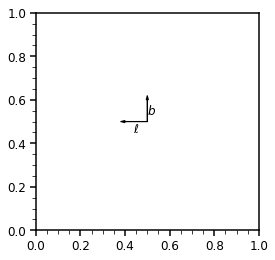

In [21]:
# make a nice arrow for later placing on the figure.

plt.figure(figsize=(4,4))

plt.arrow(0.5,0.5,-0.1,0.0,head_width=0.01, head_length=0.02)
plt.arrow(0.5,0.5,0.0,0.1,head_width=0.01, head_length=0.02)
plt.text(0.45,0.465,'$\ell$',size=12,ha='center',va='center')
plt.text(0.52,0.55,'$b$',size=12,ha='center',va='center')


plt.savefig('figures/arrow.png',dpi=400)